In [1]:
import torch
import numpy as np

In [2]:
# 每次送入网络的数据个数
BATCH_SIZE = 10
# 迭代次数
EPOCHS = 50
# 采用cpu还是gpu进行计算
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 学习率
LR = 1e-3  # 科学计数法，就是0.001

# Load and Visualize the Data

In [18]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 将图片大小统一成32*32
    transforms.ToTensor(),  # 将数据转换为Tensor格式
])
# 数据加载
train_dataset = datasets.ImageFolder('Data/Train', transform)
# 对应文件夹的label
print("size of train_dataset:",len(train_dataset))
print(train_dataset.class_to_idx)
test_dataset = datasets.ImageFolder('Data/Val', transform)
print("size of test_dataset:",len(test_dataset))
# 对应文件夹的label
print(test_dataset.class_to_idx)
# 导入数据 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

size of train_dataset: 500
{'swipe_down_to_up': 0, 'swipe_left_to_right': 1}
size of test_dataset: 102
{'swipe_down_to_up': 0, 'swipe_left_to_right': 1}


In [19]:
# for i in train_loader:
#     print(i)
print(len(train_loader))

50


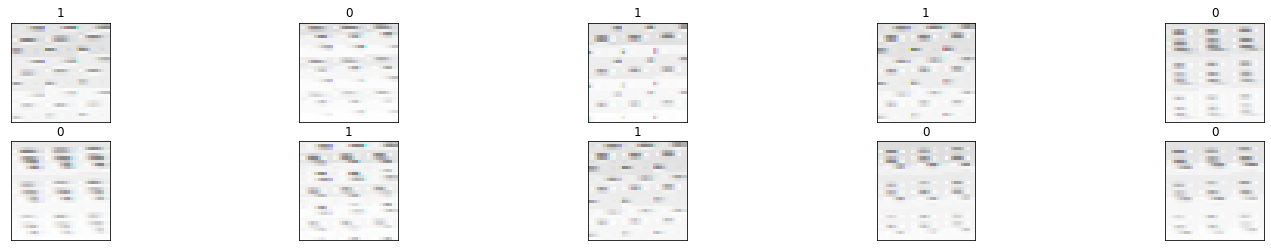

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# print(images[0])
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(2, int(BATCH_SIZE/2), idx+1, xticks=[], yticks=[])
#     print(images[idx].reshape(32, 32, 3).shape)
    ax.imshow(np.squeeze(images[idx].reshape(32, 32, 3)), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

Build Model_1

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pdb

# torch imports
import torch
from torch.utils.data import DataLoader,Dataset
from torch import optim,nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable

# model
class ResBlk(nn.Module):
    """
    resnet block
    """

    def __init__(self, ch_in, ch_out, stride=1):
        """

        :param ch_in:
        :param ch_out:
        """
        super(ResBlk, self).__init__()

        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()

        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        """
        :param x: [b, ch, h, w]
        :return:
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # short cut
        # extra module:[b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = self.extra(x) + out
        out = F.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm2d(64)
        )
        # followed 4 blocks

        # [b, 64, h, w] => [b, 128, h, w]
        self.blk1 = ResBlk(64, 128, stride=2)

        # [b, 128, h, w] => [b, 256, h, w]
        self.blk2 = ResBlk(128, 256, stride=2)

        # [b, 256, h, w] => [b, 512, h, w]
        self.blk3 = ResBlk(256, 512, stride=2)

        # [b, 512, h, w] => [b, 512, h, w]
        self.blk4 = ResBlk(512, 512, stride=2)

        self.outlayer = nn.Linear(512 * 1 * 1, 2)

    def forward(self, x):
        """

        :param x:
        :return:
        """
        # [b, 1, h, w] => [b, 64, h, w]
        x = F.relu(self.conv1(x))

        # [b, 64, h, w] => [b, 512, h, w]
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        x = self.blk4(x)

        # print(x.shape) # [b, 512, 1, 1]
        # 意思就是不管之前的特征图尺寸为多少，只要设置为(1,1)，那么最终特征图大小都为(1,1)
        # [b, 512, h, w] => [b, 512, 1, 1]
        x = F.adaptive_avg_pool2d(x, [1, 1])
        x = x.view(x.size(0), -1)
        x = self.outlayer(x)

        return x

In [22]:
# define device 
device = torch.device("cuda:0")

blk = ResBlk(3, 128, stride=4)
tmp = torch.randn(512, 3, 32, 32)
out = blk(tmp)
print('blk', out.shape)
# data for plotting purposes
modelLoss = []

# model
# model = ResNet(BasicBlock, [2,2,2,2])
model = ResNet18()
x = torch.randn(512, 3, 32, 32)
out = model(x)
print('resnet', out.shape)
print(model)
model.to(device)

opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

epochs = 50

blk torch.Size([512, 128, 8, 8])
resnet torch.Size([512, 2])
ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blk1): ResBlk(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (extra): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blk2): ResBlk(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2):

Train Model_1

In [23]:
print(train_loader)

In [24]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 100-150 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0
    total = 0
    
    for data, target in train_loader:
        
        # implement your code here
        inputs = data
        inputs = inputs.to(device)
        target = target.to(device)
#         print(data, target)
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        opt.step()
        train_loss += loss.item()# the total loss of this batch
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        
        total_correct += (predicted == target).sum().item()# the accumulated number of correctly classified samples of this batch
        
    # print training statistics 
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}%'.format(
        epoch+1, 
        train_loss, 
        train_acc
        ))

Epoch: 1 	Training Loss: 0.006543 	Training Acc: 97.80%
Epoch: 2 	Training Loss: 0.004578 	Training Acc: 98.40%
Epoch: 3 	Training Loss: 0.002275 	Training Acc: 99.20%
Epoch: 4 	Training Loss: 0.002600 	Training Acc: 99.20%
Epoch: 5 	Training Loss: 0.000377 	Training Acc: 100.00%
Epoch: 6 	Training Loss: 0.008444 	Training Acc: 97.80%
Epoch: 7 	Training Loss: 0.000459 	Training Acc: 100.00%
Epoch: 8 	Training Loss: 0.000172 	Training Acc: 100.00%
Epoch: 9 	Training Loss: 0.000188 	Training Acc: 100.00%
Epoch: 10 	Training Loss: 0.000128 	Training Acc: 100.00%
Epoch: 11 	Training Loss: 0.000162 	Training Acc: 100.00%
Epoch: 12 	Training Loss: 0.000138 	Training Acc: 100.00%
Epoch: 13 	Training Loss: 0.005044 	Training Acc: 98.40%
Epoch: 14 	Training Loss: 0.001057 	Training Acc: 99.80%
Epoch: 15 	Training Loss: 0.001016 	Training Acc: 99.40%
Epoch: 16 	Training Loss: 0.000243 	Training Acc: 100.00%
Epoch: 17 	Training Loss: 0.000095 	Training Acc: 100.00%
Epoch: 18 	Training Loss: 0.000

Test Model_1

In [25]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval() # prep model for *evaluation*

correct = 0
total = 0
for data, target in test_loader:
    
    # implement your code here
    inputs = data
    inputs = inputs.to(device)
    target = target.to(device)
    opt.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, target)
    loss.backward()
    opt.step()
    test_loss += loss.item()# the total loss of this batch
    _, predicted = torch.max(outputs.data, 1)
    total += target.size(0)
    print("target", target)
    print("predicted", predicted)
    correct += (predicted == target).sum().item()
#     for i in range(20):
#         if target[i].item() == predicted[i].item():
#             class_correct[target[i].item()] += 1
#         class_total[target[i].item()] += 1
#     print("接下来是target值：")
#     print(target)
#     print("接下来是预测值：")
#     print(predicted)
#     print("接下来是答对值：")
#     print((predicted == target).sum().item())
#     print("接下来是label值：")
#     print(label)
#     class_correct[label] += (predicted == target).sum().item()# the list of number of correctly classified samples of each class of this batch. label is the index.
#     class_total[label] += 1# the list of total number of samples of each class of this batch. label is the index.

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
#     else:
#         print('Test Accuracy of class %d: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %.2f%%' % (100. * correct / total))

target tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
predicted tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
target tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
predicted tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
target tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
predicted tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
target tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
predicted tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
target tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
target tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
predicted tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
target tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
predicted tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
target tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
predicted tensor([0, 1, 0, 1, 0, 0